In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import nlopt
from meep_material import lorentzfit

In [2]:
lambda_min = 0.4
lambda_max = 0.7
fmin = 1 / lambda_min
fmax = 1 / lambda_max
fcen = 0.5 * (fmin+fmax)
df = fmax - fmin
resolution = 200
nfreq = 25

In [3]:
def Material_fit(Material_data_csv=".", 
                   eps_inf=1,
                   fit_wl_min=0.38, fit_wl_max=0.72,
                   num_lorentzians=2, iteration=30
                   ):    

    # 1. 데이터 로드 및 전처리
    data = np.genfromtxt(Material_data_csv, delimiter=",")
    wl = data[:, 0] * 1e6  # 파장 (µm)
    n_data = data[:, 1] + 1j * data[:, 2]
    eps_all = np.square(n_data) - eps_inf

    # 피팅 범위로 데이터 선택
    mask = (wl >= fit_wl_min) & (wl <= fit_wl_max)
    wl_fit, eps_fit = wl[mask], eps_all[mask]
    freqs_fit = 1 / wl_fit

    # 2. Lorentzian 피팅 최적화
    ps = np.zeros((iteration, 3 * num_lorentzians))
    errors = np.zeros(iteration)
    for m in range(iteration):
        p_rand = [10 ** np.random.random() for _ in range(3 * num_lorentzians)]
        ps[m, :], errors[m] = lorentzfit(p_rand, freqs_fit, eps_fit, nlopt.LD_MMA, 1e-25, 50000)
        print(f"Iteration {m:3d}, error: {errors[m]:.6f}")
    best = np.argmin(errors)
    print(f"Optimal error: {errors[best]:.6f}")

    # 3. 최적 파라미터로 Susceptibility 생성 및 Meep 모델 구성
    suscept = []
    for i in range(num_lorentzians):
        freq_param = ps[best][3*i + 1]
        gamma = ps[best][3*i + 2]
        if freq_param == 0:
            sigma = ps[best][3*i + 0]
            suscept.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
        else:
            sigma = ps[best][3*i + 0] / freq_param**2
            suscept.append(mp.LorentzianSusceptibility(frequency=freq_param, gamma=gamma, sigma=sigma))

    return eps_inf, suscept

sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/SiO2/CSV/SiO2_palik_data.csv"
al_data_path = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/Al_Palik/CSV/Al_palik_data.csv"
andp_data_path = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/aNDP/CSV/aNPD_PFA_data.csv"

eps_inf_sio2, suscept_sio2 = Material_fit(Material_data_csv=sio2_data_path)
eps_inf_al, suscept_al = Material_fit(Material_data_csv=al_data_path)
eps_inf_andp, suscept_andp = Material_fit(Material_data_csv=andp_data_path)

Iteration   0, error: 0.000010
Iteration   1, error: 0.000013
Iteration   2, error: 0.000008
Iteration   3, error: 0.000085
Iteration   4, error: 0.000027
Iteration   5, error: 0.000011
Iteration   6, error: 0.000005
Iteration   7, error: 0.000016
Iteration   8, error: 0.000022
Iteration   9, error: 0.000254
Iteration  10, error: 0.000009
Iteration  11, error: 0.000011
Iteration  12, error: 0.000004
Iteration  13, error: 0.000038
Iteration  14, error: 0.000009
Iteration  15, error: 0.000016
Iteration  16, error: 0.000013
Iteration  17, error: 0.000014
Iteration  18, error: 0.000017
Iteration  19, error: 0.000015
Iteration  20, error: 0.000009
Iteration  21, error: 0.000013
Iteration  22, error: 0.000019
Iteration  23, error: 0.000004
Iteration  24, error: 0.000013
Iteration  25, error: 0.000014
Iteration  26, error: 0.000003
Iteration  27, error: 0.000009
Iteration  28, error: 0.000011
Iteration  29, error: 0.000007
Optimal error: 0.000003
Iteration   0, error: 54.483567
Iteration   1,

In [4]:
Glass = mp.Medium(epsilon=eps_inf_sio2, E_susceptibilities=suscept_sio2) # SiO2 
aNDP = mp.Medium(epsilon=eps_inf_andp, E_susceptibilities = suscept_andp) # aNDP 
Cathode = mp.Medium(epsilon=eps_inf_al, E_susceptibilities = suscept_al) # Al

In [5]:
### ----- Refractive index ----- ###
CoverLayer = mp.Medium(index=1.9) # SiN 
ITO_m = mp.Medium(index=1.8) 
Alq3 = mp.Medium(index=1.68) 
Air = mp.Medium(index=1.0) # 공기

In [6]:
Glass_layer = 1.37
Cover_layer = 0.07
ITO_layer = 0.15
aNDP_layer = 0.05
Alq3_layer = 0.06
Cathode_layer = 0.3

pml_layer = 0.3

print(Glass_layer+Cover_layer+Cathode_layer+aNDP_layer+ITO_layer+Alq3_layer)

2.0


In [7]:
boundary_layers = [
    mp.PML(thickness=pml_layer, direction=mp.X, side=mp.Low),  # 좌측 PML
    mp.PML(thickness=pml_layer, direction=mp.X, side=mp.High), # 우측 PML
    mp.PML(thickness=pml_layer, direction=mp.Y, side=mp.High), # 상단 PML
]

In [8]:
geometry = [
    # Cathode (하단)
    mp.Block(
        center=mp.Vector3(0, -0.85, 0),
        size=mp.Vector3(30, Cathode_layer, 0),
        material=Cathode
    ),
    # Alq3
    mp.Block(
        center=mp.Vector3(0, -0.67, 0),
        size=mp.Vector3(30, Alq3_layer, 0),
        material=Alq3
    ),
    # aNDP
    mp.Block(
        center=mp.Vector3(0, -0.615, 0),
        size=mp.Vector3(30, aNDP_layer, 0),
        material=aNDP
    ),
    # ITO
    mp.Block(
        center=mp.Vector3(0, -0.515, 0),
        size=mp.Vector3(30, ITO_layer, 0),
        material=ITO_m
    ),
    # Cover layer
    mp.Block(
        center=mp.Vector3(0, -0.405, 0),
        size=mp.Vector3(30, Cover_layer, 0),
        material=CoverLayer
    ),
    # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
    mp.Block(
        center=mp.Vector3(0, 0.315, 0),
        size=mp.Vector3(30, Glass_layer, 0),
        material=Glass
    )
]

In [9]:
cell_size = mp.Vector3(30, 2, 0)

In [10]:
source_center = mp.Vector3(0,-0.67,0)
sources = [mp.Source(
    src=mp.ContinuousSource(frequency=fcen, fwidth=df),
    component=mp.Ey,
    center=source_center
)]

In [11]:
# === 시뮬레이션 설정 === #
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (0,0.315,0)
          size (30,1.37,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


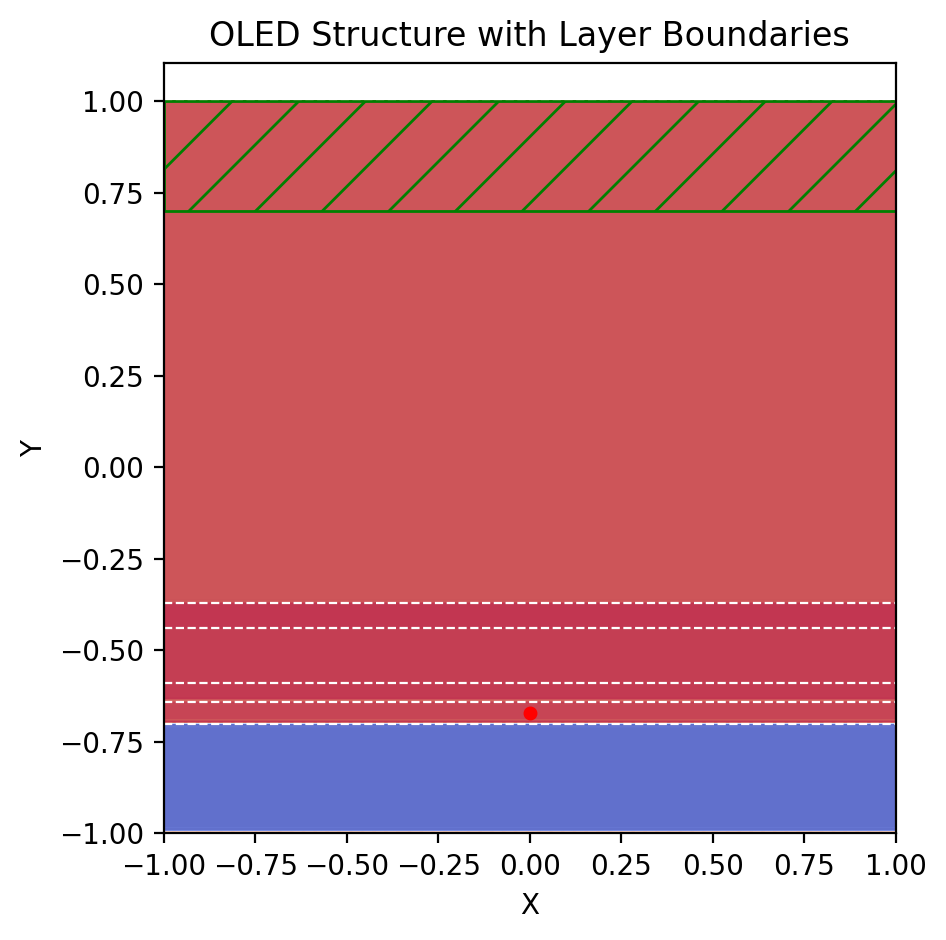

In [12]:
fig = plt.figure(dpi=200)
ax = plt.gca()
sim.plot2D(
    output_plane=mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(2, 2, 0)),
    eps_parameters={'cmap': 'coolwarm', 'alpha': 0.8},   # 투명도와 컬러맵
    ax=ax
)

layer_boundaries = [
    -1.00,  # bottom of Cathode
    -0.70,  # Cathode-Alq3
    -0.64,  # Alq3-aNDP
    -0.59,  # aNDP-ITO
    -0.44,  # ITO-Cover
    -0.37,  # Cover-Glass
    1.005   # top of Glass
]

for y in layer_boundaries:
    ax.axhline(y=y, color='white', linestyle='--', linewidth=0.8)

# === 옵션 ===
plt.title("OLED Structure with Layer Boundaries")
plt.tight_layout()
plt.show()

     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (0,0.315,0)
          size (30,1.37,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


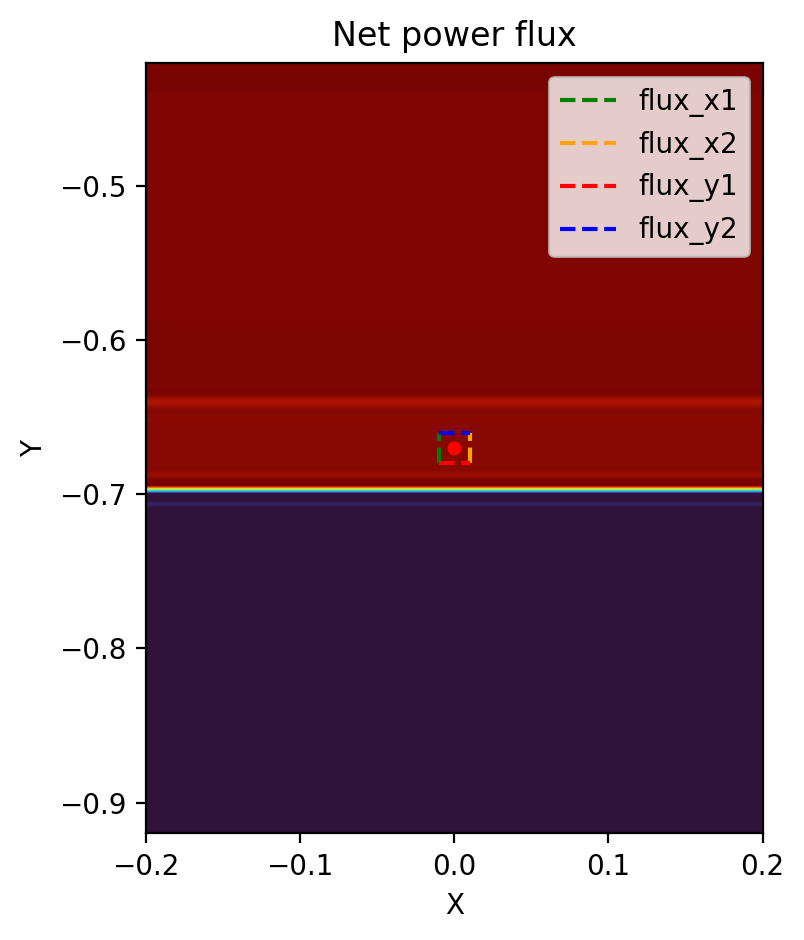

In [13]:
offset = 0.01
flux_size_x = 0.02  # y방향 길이
flux_size_y = 0.02  # x방향 길이
dipole_pos = source_center

fig = plt.figure(dpi=200)
ax = plt.gca()

# --- 기본 구조 플롯 ---
sim.plot2D(
    output_plane=mp.Volume(center=mp.Vector3(0, -0.67,0), size=mp.Vector3(0.4, 0.5, 0)),
    eps_parameters={'cmap': 'turbo', 'alpha': 1.0},
    # plot_eps_flag=True,
    # plot_sources_flag=True,
    # plot_boundaries_flag=True,
    # plot_geometry_flag=True,
    ax=ax
)

# --- 정확한 박스 모니터 박스 형태로 그리기 (x1/x2/y1/y2만큼만) ---
# flux_x1 (수직선)
ax.plot(
    [dipole_pos.x - offset] * 2,
    [dipole_pos.y - flux_size_x/2, dipole_pos.y + flux_size_x/2],
    color='green', linestyle='--', label='flux_x1'
)

# flux_x2
ax.plot(
    [dipole_pos.x + offset] * 2,
    [dipole_pos.y - flux_size_x/2, dipole_pos.y + flux_size_x/2],
    color='orange', linestyle='--', label='flux_x2'
)

# flux_y1 (수평선)
ax.plot(
    [dipole_pos.x - flux_size_y/2, dipole_pos.x + flux_size_y/2],
    [dipole_pos.y - offset] * 2,
    color='red', linestyle='--', label='flux_y1'
)

# flux_y2
ax.plot(
    [dipole_pos.x - flux_size_y/2, dipole_pos.x + flux_size_y/2],
    [dipole_pos.y + offset] * 2,
    color='blue', linestyle='--', label='flux_y2'
)

plt.legend()
plt.title("Net power flux")
plt.tight_layout()
plt.show()

In [14]:
# --- Flux 모니터 4면 등록 (tight box 기준) ---
offset = 0.02
flux_size_x = 0.01
flux_size_y = 0.01

# Dipole 위치
source_center = mp.Vector3(0, -0.67)

# 박스 4면
flux_x1 = sim.add_flux(fcen, df, nfreq, mp.FluxRegion(
    center=source_center - mp.Vector3(offset, 0),
    size=mp.Vector3(flux_size_x, flux_size_y),
    direction=mp.X,
    weight=-1
))

# flux_x2 = sim.add_flux(fcen, df, nfreq, mp.FluxRegion(
#     center=source_center + mp.Vector3(offset, 0),
#     size=mp.Vector3(0, flux_size_x),
#     direction=mp.X
# ))

# flux_y1 = sim.add_flux(fcen, df, nfreq, mp.FluxRegion(
#     center=source_center - mp.Vector3(0, offset),
#     size=mp.Vector3(flux_size_y, 0),
#     direction=mp.Y,
#     weight=-1
# ))

# flux_y2 = sim.add_flux(fcen, df, nfreq, mp.FluxRegion(
#     center=source_center + mp.Vector3(0, offset),
#     size=mp.Vector3(flux_size_y, 0),
#     direction=mp.Y
# ))

In [15]:
# --- 시뮬레이션 실행 ---
sim.run(until_after_sources=mp.stop_when_fields_decayed(
    50, mp.Ey, source_center, 1e-3))

# --- Flux 값 얻기 ---
Px1 = np.array(mp.get_fluxes(flux_x1))
print(Px1)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000607967 s
Working in 2D dimensions.
Computational cell is 30 x 2 x 0 with resolution 200
     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, 

KeyboardInterrupt: 

In [ ]:
# Px2 = np.array(mp.get_fluxes(flux_x2))
# Py1 = np.array(mp.get_fluxes(flux_y1))
# Py2 = np.array(mp.get_fluxes(flux_y2))

net_power = Px1 #+ Px2 + Py1 + Py2  # dipolepower_box

frequencies = mp.get_flux_freqs(flux_x1)
wavelengths = [1/f for f in frequencies]

# --- 출력 ---
print("λ (μm)\t\tdipolepower_box (W)")
for i in range(nfreq):
    print(f"{wavelengths[i]:.4f}\t\t{net_power[i]:.6e}")

λ (μm)		dipolepower_box (W)
0.4000		0.000000e+00
0.4073		0.000000e+00
0.4148		0.000000e+00
0.4226		0.000000e+00
0.4308		0.000000e+00
0.4392		0.000000e+00
0.4480		0.000000e+00
0.4571		0.000000e+00
0.4667		0.000000e+00
0.4766		0.000000e+00
0.4870		0.000000e+00
0.4978		0.000000e+00
0.5091		0.000000e+00
0.5209		0.000000e+00
0.5333		0.000000e+00
0.5463		0.000000e+00
0.5600		0.000000e+00
0.5744		0.000000e+00
0.5895		0.000000e+00
0.6054		0.000000e+00
0.6222		0.000000e+00
0.6400		0.000000e+00
0.6588		0.000000e+00
0.6788		0.000000e+00
0.7000		0.000000e+00


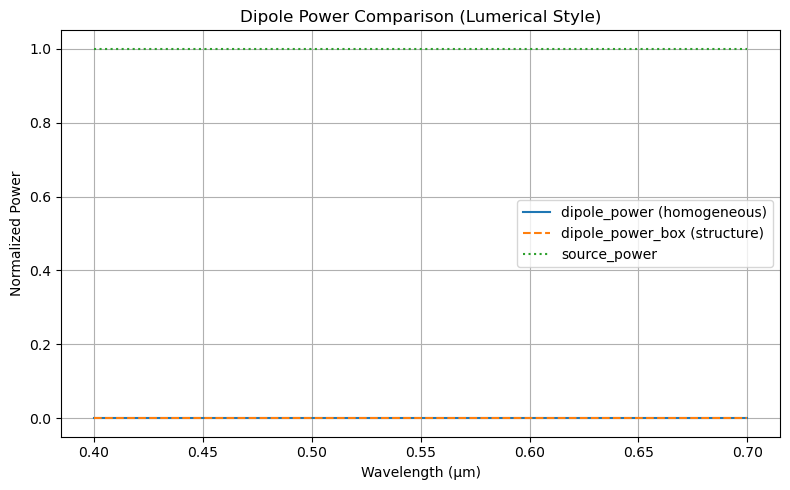

In [ ]:
frequencies = np.linspace(fmin, fmax, nfreq)
wavelengths = 1 / frequencies  # 단위: μm

dipole_power_box = np.array(net_power)  # net_power는 box monitor 측정값
source_power = np.ones(nfreq)           # 1로 가정
dipole_power = np.array(net_power)      # 현재는 box값 복사, 실제 homogeneous 구조에서 측정 필요

# === 정규화 ===
dp_box_norm = dipole_power_box / source_power
dp_norm = dipole_power / source_power

# === Plot ===
plt.figure(figsize=(8,5))
plt.plot(wavelengths, dp_norm, label="dipole_power (homogeneous)", linestyle='-')
plt.plot(wavelengths, dp_box_norm, label="dipole_power_box (structure)", linestyle='--')
plt.plot(wavelengths, source_power, label="source_power", linestyle=':')

plt.xlabel("Wavelength (μm)")
plt.ylabel("Normalized Power")
plt.title("Dipole Power Comparison (Lumerical Style)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()